# **Modeling and prediction -  SalePrice**

## Objectives

* Engineer features for Classification, Regression and Cluster models

## Inputs

* outputs/datasets/collection/HousePriceRecord.csv
* Pipeline transformers that ca be found in PriceSaleStudy, DataCleaning and Feature Engineering

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict PriceSale
* labels map
*Feature Importance Plot

## Conclusions

...


---

# Change working directory


* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heriting-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/heriting-housing-issues'

---

# Load Data

We drop WoodDeckSF

In [5]:
import numpy as np
import pandas as pd
df1 = (pd.read_csv("outputs/datasets/collection/HousePriceRecord.csv").drop(labels=['WoodDeckSF'], axis=1))

print(df1.shape)
df1.head(3)

(1460, 23)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500


# ML Pipeline with all data

## ML Pipeline for Modelling and Hyperparameter Optimisation

The below pipeline transformer are taken from the PriceSaleStudy, Datacleaning and Feature Engineering analysis.

In [6]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ( 'arbitrary_number_zero',  ArbitraryNumberImputer(arbitrary_number=0,
                                                    variables=['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea']) ),

        ( 'median',  MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage']) ),

        ( 'categorical_imputer', CategoricalImputer(imputation_method='frequent', variables=['BsmtFinType1', 'GarageFinish']) ),

        ( 'ordinal_encoder', OrdinalEncoder(encoding_method='arbitrary', variables = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']) ),

        ( 'yeo_johnson', vt.YeoJohnsonTransformer(variables = ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'GarageArea', 'YearRemodAdd', 'GrLivArea',
                                                                'OverallQual', 'OpenPorchSF', 'LotArea', 'YearBuilt', 'MasVnrArea', 'LotFrontage']) ),
                                                                
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

The below function is a custom function taken from Code Institute walkthrough project #2. It runs GridSearchCV trough the pipeline and creates a table to show the performance of each transformer in a table.

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split the dataset

we drop the feature PriceSale as it is the target.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df1.drop(['SalePrice'], axis=1),
    df1['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 22) (1168,) 
* Test set: (292, 22) (292,)


## Apply the ML for Data Cleaning on the datasets

In [9]:
X_train.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
618,1828,0.0,NaN,Av,48,NaN,1774,NaN,774,Unf,...,Gd,11694,90.0,452.0,108,5,9,1822,2007,2007
870,894,0.0,2.0,No,0,Unf,894,NaN,308,NaN,...,TA,6600,60.0,0.0,0,5,5,894,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,NaN,432,Unf,...,TA,13360,80.0,0.0,0,7,5,876,1921,2006
817,1689,0.0,3.0,No,1218,GLQ,350,NaN,857,RFn,...,Gd,13265,NaN,148.0,59,5,8,1568,2002,2002
302,1541,0.0,3.0,No,0,Unf,1541,NaN,843,RFn,...,Gd,13704,118.0,150.0,81,5,7,1541,2001,2002


## Target Imbalance

As mention in the SalePriceStudy, Target Imbalance handling is not required in this ML since the SalePrice is well distributed.

## Grid Search CV

We initially run Grid Search CV to find the optimal regressor with the default hyperparameter./

In [10]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [11]:

search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.707091,0.762671,0.800332,0.030645
5,GradientBoostingRegressor,0.64266,0.761599,0.845895,0.067664
2,RandomForestRegressor,0.618586,0.751698,0.815419,0.068831
0,LinearRegression,0.653162,0.74011,0.835487,0.059205
6,XGBRegressor,0.637822,0.70255,0.81969,0.06405
4,AdaBoostRegressor,0.656483,0.698049,0.742785,0.037059
1,DecisionTreeRegressor,0.352005,0.563148,0.681845,0.112503


**The result shows that ExtraTreesRegressor is the best transformer for our database with a mean score of 0.76.** 

## Hyperparameter optimization


In [13]:
models_quick_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
                          'model__max_depth': [None, 3, 15],
                          'model__min_samples_split': [2, 50],
                          'model__min_samples_leaf': [1,50],
                            }
  }

In [14]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou

We can extract the best model and best parameters from the grid_search_summary

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
26,ExtraTreesRegressor,0.702092,0.765565,0.79893,0.033203,15,1,2,150
24,ExtraTreesRegressor,0.695566,0.765066,0.797245,0.035717,15,1,2,100
25,ExtraTreesRegressor,0.685567,0.764392,0.798423,0.040402,15,1,2,50
2,ExtraTreesRegressor,0.707397,0.763426,0.799678,0.03055,None,1,2,150
3,ExtraTreesRegressor,0.714062,0.762715,0.799289,0.035095,None,1,50,100
27,ExtraTreesRegressor,0.714092,0.762705,0.799289,0.035071,15,1,50,100
0,ExtraTreesRegressor,0.707091,0.762671,0.800332,0.030645,None,1,2,100
29,ExtraTreesRegressor,0.71419,0.762663,0.800494,0.0357,15,1,50,150
5,ExtraTreesRegressor,0.714205,0.762625,0.800552,0.035739,None,1,50,150
4,ExtraTreesRegressor,0.711978,0.761128,0.796159,0.033848,None,1,50,50


In [16]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [17]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

We define the best pipeline

In [18]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('arbitrary_number_zero',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'EnclosedPorch',
                                                   'MasVnrArea'])),
                ('median',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'GarageYrBlt',
                                              'LotFrontage'])),
                ('categorical_imputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtFinType1',
                                               'GarageFinish'])),
                ('ordinal_enc...
                                                  'YearBuilt', 'MasVnrArea',
                                                  'LotFrontage'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=15, n_estimators=150,
                                     random_state=0))])

## Assess feature importance

In [19]:
X_train.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
618,1828,0.0,NaN,Av,48,NaN,1774,NaN,774,Unf,...,Gd,11694,90.0,452.0,108,5,9,1822,2007,2007
870,894,0.0,2.0,No,0,Unf,894,NaN,308,NaN,...,TA,6600,60.0,0.0,0,5,5,894,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,NaN,432,Unf,...,TA,13360,80.0,0.0,0,7,5,876,1921,2006


* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', 'GarageArea', 'YearRemodAdd']


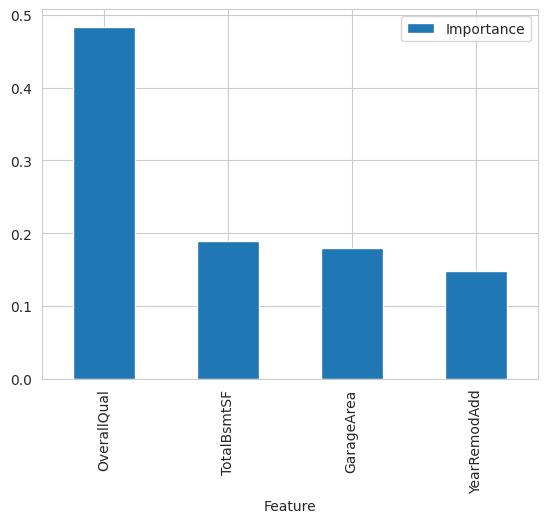

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 6
columns_after_data_cleaning_feat_eng = (Pipeline(best_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_pipeline['feat_selection'].get_support()],
    'Importance': best_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [21]:
best_features

['GarageArea', 'OverallQual', 'TotalBsmtSF', 'YearRemodAdd']

## Evaluate Regressor Pipeline on Train and Test Sets

The below function is taken from Code Institute Walkthough project #2. It run the a pipeline on both Train and Test set and print the results in 2 tables and plot prediction compare to actual for both set.

In [22]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.995
Mean Absolute Error: 3247.693
Mean Squared Error: 31196941.086
Root Mean Squared Error: 5585.422


* Test Set
R2 Score: 0.745
Mean Absolute Error: 26032.356
Mean Squared Error: 1761065364.449
Root Mean Squared Error: 41965.049




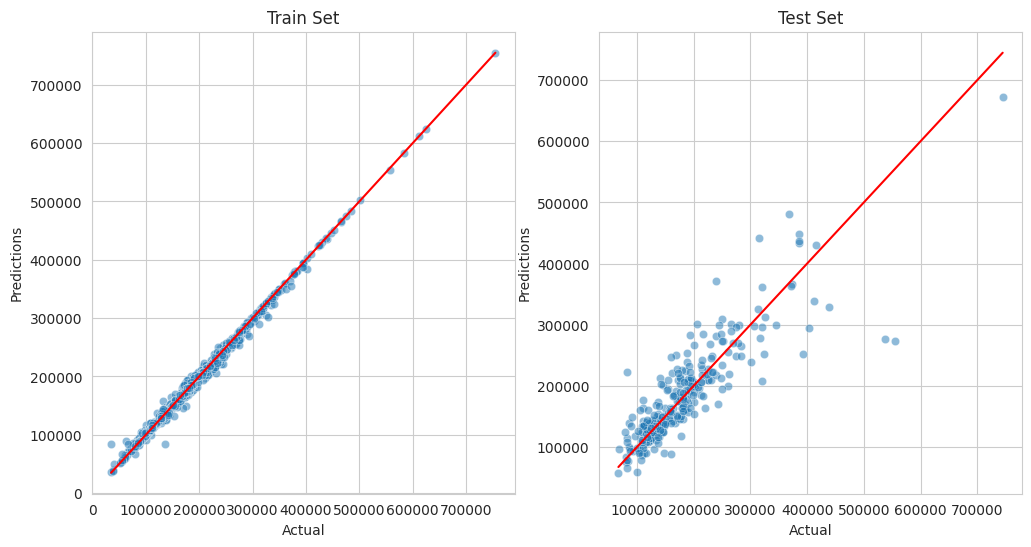

In [23]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline)

We can see that our pipeline is a little bit overfit but still have good prediction on the test set with a R2 = 0.745. Unfortunately, the client has asked for a R2 to be greater or equal to 0.75. Lets do addition analysis to see if we can get this requirement.

## Regressor with PCA

The regressor with PCA will analyse the data using a number of components that together explains more then 70% of the data. We hope to increase R2 on the test set above 0.75 by using this model.

In [25]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:7])
df_pca = pipeline_pca.fit_transform(df1.drop(['SalePrice'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 18) 
 <class 'numpy.ndarray'>


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


* The 18 components explain 100.0% of the data 



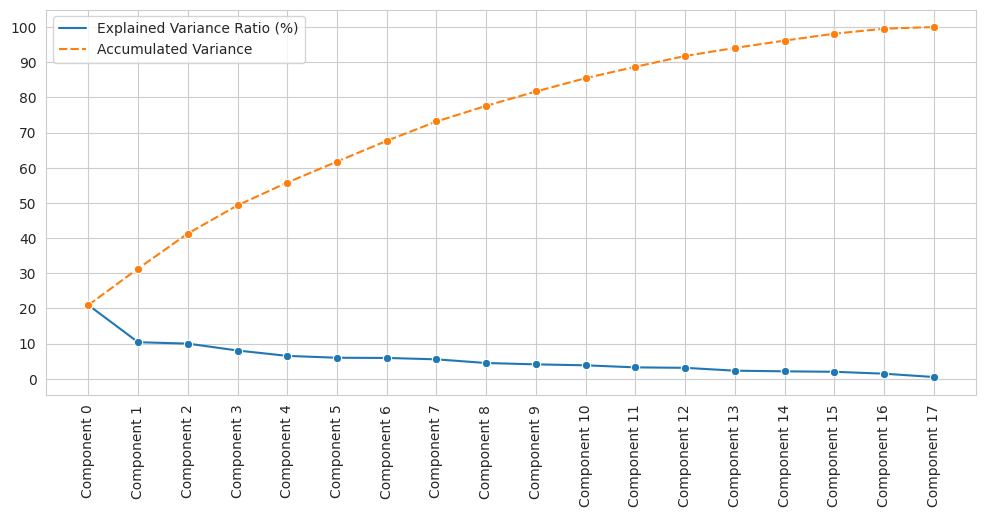

In [27]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 18


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

We aim to choose as less components as possible to cover at least 70% explaination of the data.

* The 8 components explain 73.14% of the data 



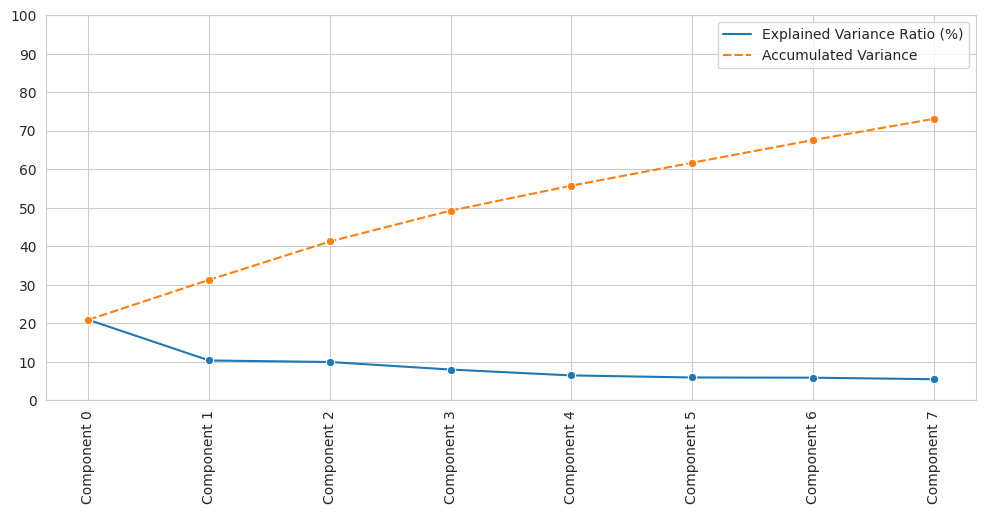

In [29]:
n_components = 8
pca_components_analysis(df_pca=df_pca, n_components=n_components)

### Rewrite ML Pipeline with PCA model

In [30]:
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ( 'arbitrary_number_zero',  ArbitraryNumberImputer(arbitrary_number=0,
                                                    variables=['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea']) ),

        ( 'median',  MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage']) ),

        ( 'categorical_imputer', CategoricalImputer(imputation_method='frequent', variables=['BsmtFinType1', 'GarageFinish']) ),

        ( 'ordinal_encoder', OrdinalEncoder(encoding_method='arbitrary', variables = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']) ),

        ( 'yeo_johnson', vt.YeoJohnsonTransformer(variables = ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'GarageArea', 'YearRemodAdd', 'GrLivArea',
                                                                'OverallQual', 'OpenPorchSF', 'LotArea', 'YearBuilt', 'MasVnrArea', 'LotFrontage']) ),
                                                                
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", model),

    ])

    return pipeline_base

### Grid Seach CV

We run the Grid Seach CV from the begining. We initialy find the best model and then we find the more optimized hyperparameters

In [31]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 22) (1168,) 
* Test set: (292, 22) (292,)


In [32]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [33]:

quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou

In [34]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.648202,0.719254,0.783095,0.049993
2,RandomForestRegressor,0.653699,0.717001,0.783616,0.047186
5,GradientBoostingRegressor,0.651192,0.710685,0.787765,0.046485
6,XGBRegressor,0.626227,0.706946,0.740792,0.041105
0,LinearRegression,0.59264,0.663601,0.730837,0.044261
4,AdaBoostRegressor,0.539573,0.64076,0.729254,0.067357
1,DecisionTreeRegressor,0.220062,0.467966,0.58202,0.134202


We optimize the Hyperparameter.

In [37]:
models_quick_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
                          'model__max_depth': [None, 3, 15],
                          'model__min_samples_split': [2, 50],
                          'model__min_samples_leaf': [1,50],
                            }
  }

In [38]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou

Examine the score

In [39]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
26,ExtraTreesRegressor,0.642914,0.72439,0.784154,0.050267,15,1,2,150
24,ExtraTreesRegressor,0.646405,0.724183,0.778729,0.048414,15,1,2,100
2,ExtraTreesRegressor,0.647328,0.722597,0.782337,0.049346,None,1,2,150
0,ExtraTreesRegressor,0.648202,0.719254,0.783095,0.049993,None,1,2,100
25,ExtraTreesRegressor,0.639324,0.718905,0.77558,0.047985,15,1,2,50
1,ExtraTreesRegressor,0.641677,0.714297,0.785199,0.055221,None,1,2,50
4,ExtraTreesRegressor,0.612563,0.713538,0.785628,0.056689,None,1,50,50
28,ExtraTreesRegressor,0.612044,0.713487,0.786332,0.056946,15,1,50,50
29,ExtraTreesRegressor,0.61388,0.712339,0.784989,0.055719,15,1,50,150
5,ExtraTreesRegressor,0.613262,0.712095,0.784099,0.055749,None,1,50,150


We can already see that the score is lower then our initial analysis. We will confirm by evaluating on the Train and Test sets.

In [41]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [42]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

In [43]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('arbitrary_number_zero',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'EnclosedPorch',
                                                   'MasVnrArea'])),
                ('median',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'GarageYrBlt',
                                              'LotFrontage'])),
                ('categorical_imputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtFinType1',
                                               'GarageFinish'])),
                ('ordinal_enc...
                                                  'GrLivArea', 'OverallQual',
                                                  'OpenPorchSF', 'LotArea',
                                                  'YearBuilt', 'MasVnrArea',
                                                  'LotFrontage'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model',
                 ExtraTreesRegressor(max_depth=15, n_estimators=150,
                                     random_state=0))])

### Evaluate PCA Regressor on Train and test sets

Model Evaluation 

* Train Set
R2 Score: 0.996
Mean Absolute Error: 3191.989
Mean Squared Error: 22102208.081
Root Mean Squared Error: 4701.299


* Test Set
R2 Score: 0.787
Mean Absolute Error: 23618.872
Mean Squared Error: 1471979299.483
Root Mean Squared Error: 38366.382




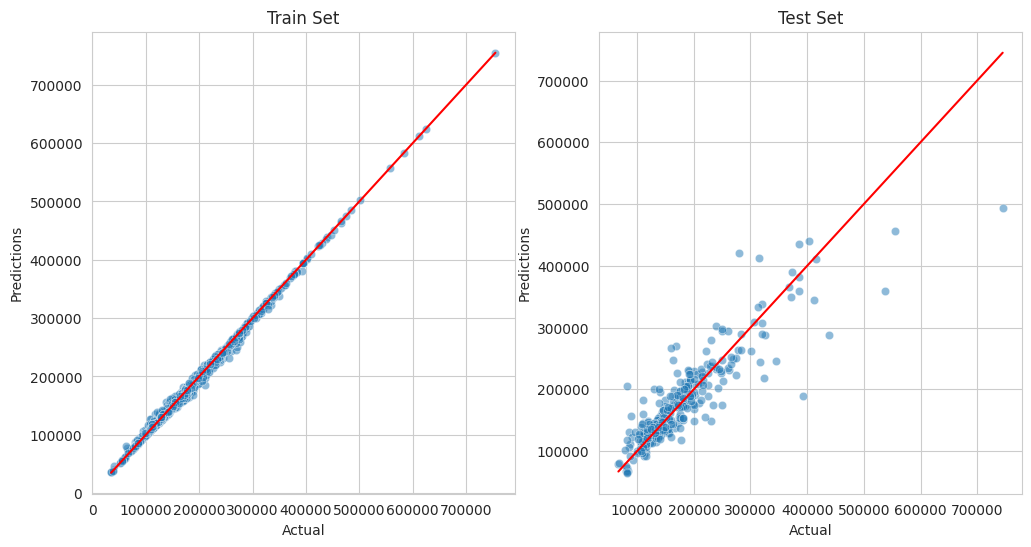

In [44]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

After using the Regressor with PCA model, we have hit our target with both Train and Test set R2. 


## Pipeline selected

First of all, we don't need to convert the model from Regression to Classification here as we hit the target with the PCA regression model.

Since only the regressor with PCA is the only model that have a score of r2 greater then 0.75, the best model to use is Regressor with PCA.

In [45]:
best_regressor_pipeline

Pipeline(steps=[('arbitrary_number_zero',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'EnclosedPorch',
                                                   'MasVnrArea'])),
                ('median',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'GarageYrBlt',
                                              'LotFrontage'])),
                ('categorical_imputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtFinType1',
                                               'GarageFinish'])),
                ('ordinal_enc...
                                                  'GrLivArea', 'OverallQual',
                                                  'OpenPorchSF', 'LotArea',
                                                  'YearBuilt', 'MasVnrArea',
                                                  'LotFrontage'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model',
                 ExtraTreesRegressor(max_depth=15, n_estimators=150,
                                     random_state=0))])

As found in the best features analysis, there are 4 most important features in the data that influence SalePrice. Unfortunately, those 4 features are not enough to get a R2 score following the client requirement. To achieve the client requirement, the PCA is using the 8 most important features.

In [46]:
best_features

['GarageArea', 'OverallQual', 'TotalBsmtSF', 'YearRemodAdd']

The best features explain still close to 50% of the data. Meaning the 4 additional data add only 22% of the explanation.

* The 4 components explain 49.3% of the data 



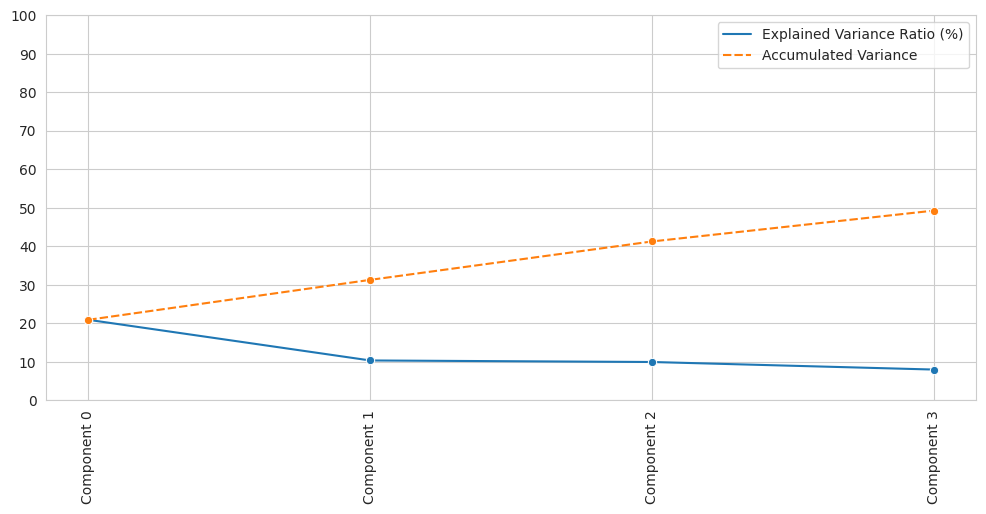

In [54]:
n_components = 4
pca_components_analysis(df_pca=df_pca, n_components=n_components)

---

# Push files to repo

The following files will be push to repo:
* Train set
* Test set
* Modeling pipeline
* features importance plot

In [55]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_SalePrice/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: features and target

In [56]:
X_train.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
618,1828,0.0,NaN,Av,48,NaN,1774,NaN,774,Unf,...,Gd,11694,90.0,452.0,108,5,9,1822,2007,2007
870,894,0.0,2.0,No,0,Unf,894,NaN,308,NaN,...,TA,6600,60.0,0.0,0,5,5,894,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,NaN,432,Unf,...,TA,13360,80.0,0.0,0,7,5,876,1921,2006
817,1689,0.0,3.0,No,1218,GLQ,350,NaN,857,RFn,...,Gd,13265,NaN,148.0,59,5,8,1568,2002,2002
302,1541,0.0,3.0,No,0,Unf,1541,NaN,843,RFn,...,Gd,13704,118.0,150.0,81,5,7,1541,2001,2002


In [57]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [58]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [59]:

y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [60]:
X_test.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
529,2515,0.0,4.0,No,1219,Rec,816,NaN,484,NaN,...,TA,32668,NaN,NaN,0,3,6,2035,1957,1975
491,958,620.0,3.0,No,403,BLQ,238,NaN,240,Unf,...,Fa,9490,79.0,0.0,0,7,6,806,1941,1950
459,979,224.0,3.0,No,185,LwQ,524,NaN,352,Unf,...,Gd,7015,NaN,161.0,0,4,5,709,1950,1950
279,1156,866.0,4.0,No,392,BLQ,768,0.0,505,Fin,...,TA,10005,83.0,299.0,117,5,7,1160,1977,1977
655,525,NaN,3.0,No,0,Unf,525,NaN,264,Unf,...,TA,1680,21.0,381.0,0,5,6,525,1971,1971


In [61]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [62]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [63]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

We push to repo the best pipeline

In [65]:
best_regressor_pipeline

Pipeline(steps=[('arbitrary_number_zero',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'EnclosedPorch',
                                                   'MasVnrArea'])),
                ('median',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'GarageYrBlt',
                                              'LotFrontage'])),
                ('categorical_imputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtFinType1',
                                               'GarageFinish'])),
                ('ordinal_enc...
                                                  'GrLivArea', 'OverallQual',
                                                  'OpenPorchSF', 'LotArea',
                                                  'YearBuilt', 'MasVnrArea',
                                                  'LotFrontage'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model',
                 ExtraTreesRegressor(max_depth=15, n_estimators=150,
                                     random_state=0))])

In [66]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/clf_pipeline.pkl")

['outputs/ml_pipeline/predict_SalePrice/v1/clf_pipeline.pkl']

## Feature importance plot

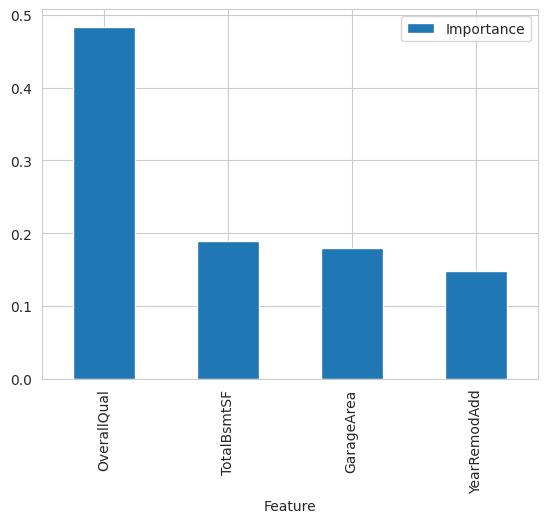

In [67]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

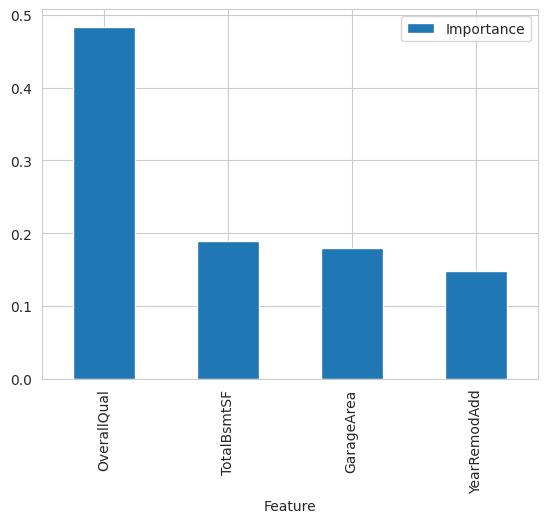

In [68]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')